In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler

In [2]:
wip_df = pd.read_csv("cleaned_women_parliament_data.csv")
wip_df.head()

,Unnamed: 0,Year,Month,Country,Country Code,Region,Subregion,Lower Total Seat,Lower Total Women,Lower Chamber Women (%),...,Transitional Status,Gender Equality,Themes,Gender Quota,Population_Weight,Weighted_Lower_Metric,Weighted_Upper_Metric,Weighted_Bicameral_Metric,Weighted_Lower_Rank,Weighted_Bicameral_Rank
0,0,2019,1,Rwanda,RW,Sub_Saharan_Africa,central_africa,80,49,61.3,...,0.0,no,womens_caucus,Yes,0.000021,0.000013,0.000008,0.000020,42,30.0
1,1,2019,1,Cuba,CU,Americas,caribbean,605,322,53.2,...,0.0,yes,finance,No,0.000020,0.000011,NaN,0.000011,48,NaN
2,2,2019,1,Bolivia,BO,Americas,south_america,130,69,53.1,...,0.0,yes,defence,Yes,0.000019,0.000010,0.000009,0.000019,50,34.0
3,3,2019,1,Mexico,MX,Americas,north_america,500,241,48.2,...,0.0,yes,finance,Yes,0.000222,0.000107,0.000109,0.000216,4,3.0
4,4,2019,1,Sweden,SE,Europe,nordic_countries,349,165,47.3,...,0.0,yes,gender_equality,Yes,0.000017,0.000008,NaN,0.000008,58,NaN


In [3]:
def plot(kind, data, x, y, title, xlabel, ylabel, legend=True, hue=None, grid=True, legend_kwargs=None,figsize=None,rotation=None, **kwargs):
    """
    A flexible function to plot different kinds of graphs using Seaborn.
    Parameters:
        kind (str): The type of plot (e.g., 'line', 'scatter', 'bar', etc.).
        data (DataFrame): The dataset to use for the plot.
        x (str): The column name for the x-axis.
        y (str): The column name for the y-axis.
        title (str): The title of the plot.
        xlabel (str): The label for the x-axis.
        ylabel (str): The label for the y-axis.
        legend (bool): Whether to show the legend (default: True).
        hue (str): The column name for grouping (default: None).
        grid (bool): Whether to display a grid (default: True).
        legend_kwargs (dict): Additional arguments for customizing the legend (default: None).
        **kwargs: Additional keyword arguments for the specific Seaborn plot.
    """
    sns.set_palette("bright")
    plt.figure(figsize=(12, 8))
    if figsize is not None:
        plt.figure(figsize=figsize)
    
    # Dynamically call the appropriate Seaborn plot function
    plot_func = getattr(sns, f"{kind}plot", None)
    if plot_func is None:
        raise ValueError(f"Plot type '{kind}' is not supported by Seaborn.")
    
    # If plotting a boxplot, explicitly pass the palette
    if kind == 'box':
        plot_func(data=data, x=x, y=y, hue=hue, palette="bright", **kwargs)
    else:
        plot_func(data=data, x=x, y=y, hue=hue, **kwargs)

    # # Create the plot
    # plot_func(data=data, x=x, y=y, hue=hue, **kwargs)
    
    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    # Add legend if applicable
    if legend and hue:
        if legend_kwargs is None:
            legend_kwargs = {}
        plt.legend(title=hue, **legend_kwargs)
    
    if grid:
        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.6)
    
    if rotation is not None:
        plt.xticks(rotation=rotation)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [4]:
wip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14089 entries, 0 to 14088
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 14089 non-null  int64  
 1   Year                       14089 non-null  int64  
 2   Month                      14089 non-null  int64  
 3   Country                    14089 non-null  object 
 4   Country Code               14089 non-null  object 
 5   Region                     14089 non-null  object 
 6   Subregion                  14089 non-null  object 
 7   Lower Total Seat           14089 non-null  int64  
 8   Lower Total Women          14089 non-null  int64  
 9   Lower Chamber Women (%)    14089 non-null  float64
 10  Upper Total Seat           14089 non-null  int64  
 11  Upper Total Women          14089 non-null  int64  
 12  Upper Chamber Women (%)    14089 non-null  float64
 13  Rank                       13758 non-null  flo

<Figure size 1200x800 with 0 Axes>

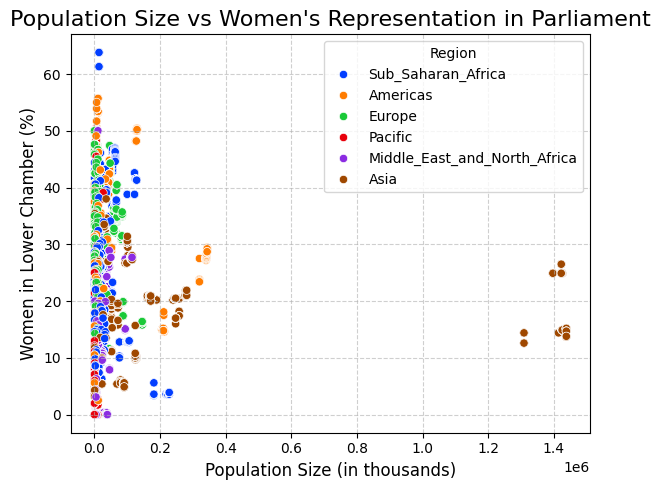

Correlation between Population Size and Women's Representation: -0.037130594257926454


In [5]:
plot('scatter',wip_df,'Population in thousands','Lower Chamber Women (%)','Population Size vs Women\'s Representation in Parliament',
     'Population Size (in thousands)','Women in Lower Chamber (%)', legend=True,hue='Region',figsize=(6,5))

# Calculate the correlation coefficient
correlation = wip_df['Population in thousands'].corr(wip_df['Lower Chamber Women (%)'])
print(f"Correlation between Population Size and Women's Representation: {correlation}")

In [6]:
# Check for missing values
print(wip_df[['Population in thousands', 'Lower Chamber Women (%)']].isnull().sum())

# Drop rows with missing values
wip_df_clean = wip_df.dropna(subset=['Population in thousands', 'Lower Chamber Women (%)'])

# Simple Linear Regression: Population Size vs Women's Representation (Lower Chamber Women %)
# Define the dependent variable (women's representation) and independent variable (population size)
X = wip_df_clean['Population in thousands']  # Independent variable (population size)
y = wip_df_clean['Lower Chamber Women (%)']  # Dependent variable (women's representation)

# Add constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

Population in thousands    0
Lower Chamber Women (%)    0
dtype: int64
                               OLS Regression Results                              
Dep. Variable:     Lower Chamber Women (%)   R-squared:                       0.001
Model:                                 OLS   Adj. R-squared:                  0.001
Method:                      Least Squares   F-statistic:                     19.45
Date:                     Sat, 01 Feb 2025   Prob (F-statistic):           1.04e-05
Time:                             17:25:50   Log-Likelihood:                -55667.
No. Observations:                    14089   AIC:                         1.113e+05
Df Residuals:                        14087   BIC:                         1.114e+05
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.97

it's important to note that the R-squared value is 0.001, which means that the model explains only 0.1% of the variance in women's representation. Despite the statistical significance, the very small R-squared suggests that population size alone is not a strong predictor of women’s representation, and other factors likely play a much larger role.

In summary:

p-value for population size: 0.000 (significant)
R-squared: 0.001 (very low, model explains very little variance)
This suggests that while population size is statistically significant, it does not explain much of the variation in women's representation in parliament, and there may be more important factors to consider (as indicated by the low R-squared).

In [7]:
X = wip_df_clean['Population in thousands']
X_poly = sm.add_constant(np.column_stack([X, X**2]))  # Adding quadratic term
model = sm.OLS(y, X_poly).fit()
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     Lower Chamber Women (%)   R-squared:                       0.001
Model:                                 OLS   Adj. R-squared:                  0.001
Method:                      Least Squares   F-statistic:                     9.912
Date:                     Sat, 01 Feb 2025   Prob (F-statistic):           4.99e-05
Time:                             17:25:50   Log-Likelihood:                -55667.
No. Observations:                    14089   AIC:                         1.113e+05
Df Residuals:                        14086   BIC:                         1.114e+05
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [ ]:
poly = PolynomialFeatures(degree=2)  # or higher degree for more flexibility
X_poly = poly.fit_transform(wip_df_clean[['Population in thousands']])
model = LinearRegression().fit(X_poly, y)

# Predict the values using the model
y_pred = model.predict(X_poly)

# Calculate R-squared and MSE
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

R-squared: 0.0014053658524718626
Mean Squared Error: 158.26095901257537


c:\Users\nuwai\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


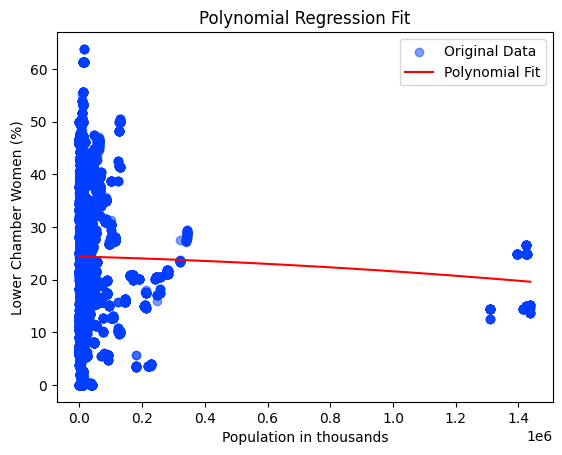

In [9]:
# Generate a range of values for plotting the curve
X_range = np.linspace(wip_df_clean['Population in thousands'].min(), wip_df_clean['Population in thousands'].max(), 100).reshape(-1, 1)
X_range_poly = poly.transform(X_range)

# Predict using the model for the new range of X values
y_range_pred = model.predict(X_range_poly)

# Plot the original data and the polynomial regression curve
plt.scatter(wip_df_clean['Population in thousands'], y, alpha=0.5, label='Original Data')
plt.plot(X_range, y_range_pred, color='red', label='Polynomial Fit')
plt.title("Polynomial Regression Fit")
plt.xlabel("Population in thousands")
plt.ylabel("Lower Chamber Women (%)")
plt.legend()
plt.show()

The red polynomial fit line is nearly flat

This suggests that changes in population size do not strongly impact the percentage of women in the lower chamber.
Data points are highly concentrated on the left

Most data points are clustered at low population values, and there is no clear curved pattern.
No significant upward/downward trends

If there were a non-linear relationship, we would expect a U-shape or S-shape curve, but the red line is mostly stable with a slight decline.

 it appears that population size has little to no influence (linear or nonlinear) on the percentage of women in the lower chamber. The data's variability suggests that other factors, beyond population size, are likely more important in explaining the differences in this metric.

 From the graph, the following observations can be made:

Visual Trend: The red polynomial fit line appears to be mostly flat with a slight downward trend. This suggests that there is little to no strong nonlinear relationship between the population (x-axis) and the percentage of women in the lower chamber (y-axis).

Dispersion: The scatterplot shows a significant spread of data points, especially for smaller populations. This indicates high variability in the percentage of women in the lower chamber, regardless of the population size.

Weak Correlation: The almost flat nature of the polynomial fit line implies that the relationship between the two variables is either very weak or non-existent. Any nonlinearity is minimal or not meaningful in this dataset.

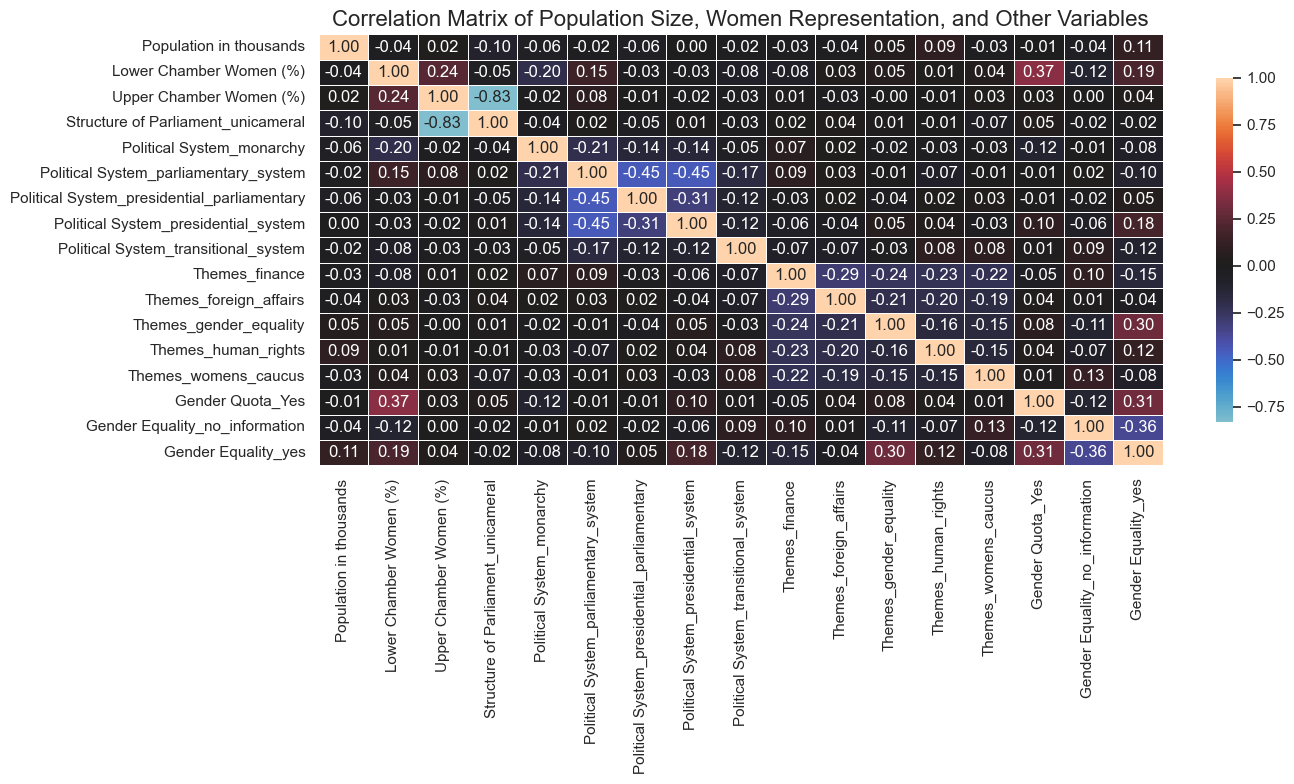

In [10]:
# Select relevant variables for the correlation matrix
correlation_df = wip_df[['Population in thousands', 'Lower Chamber Women (%)', 'Upper Chamber Women (%)',
                            'Structure of Parliament', 'Political System','Themes','Gender Quota','Gender Equality']]

# Convert categorical variables (Structure of Parliament, Political System, Region) to numerical values
correlation_df = pd.get_dummies(correlation_df, drop_first=True)

# Calculate the correlation matrix
corr_matrix = correlation_df.corr()

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5, center=0, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Population Size, Women Representation, and Other Variables', fontsize=16)
plt.tight_layout()
plt.show()

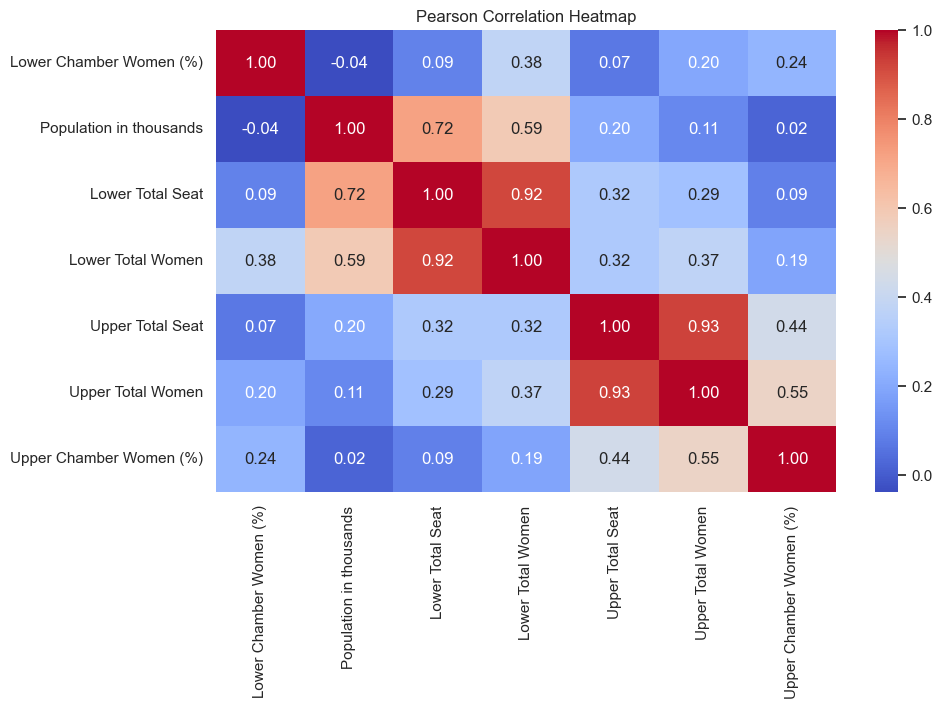

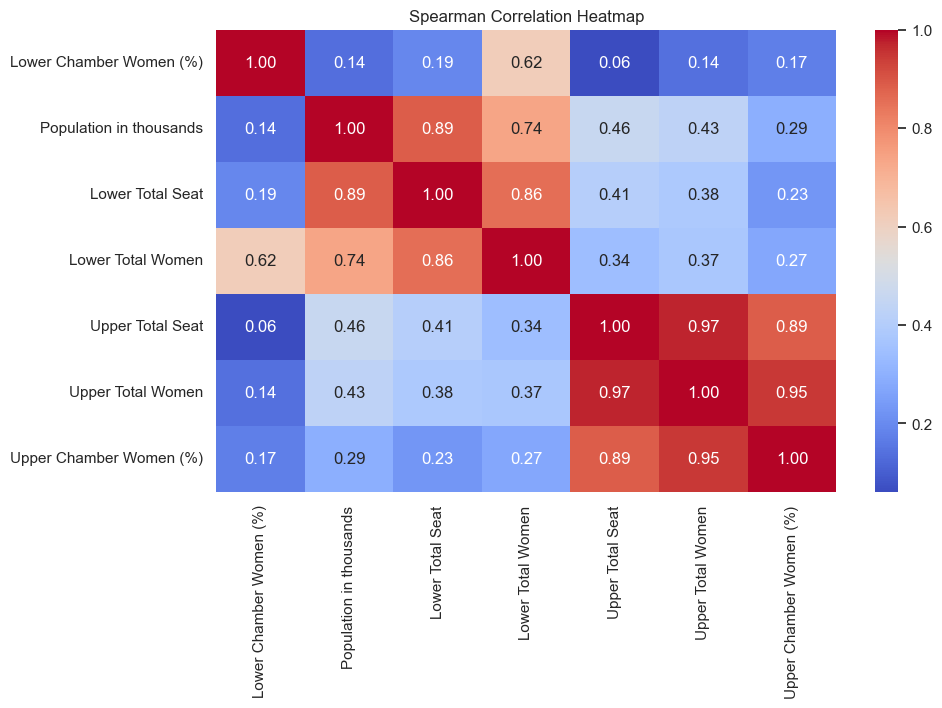

In [11]:
# Select relevant numerical features
numerical_features = ['Lower Chamber Women (%)', 'Population in thousands', 
                      'Lower Total Seat', 'Lower Total Women', 
                      'Upper Total Seat', 'Upper Total Women', 
                      'Upper Chamber Women (%)']

# Compute Pearson correlation
pearson_corr = wip_df_clean[numerical_features].corr(method='pearson')

# Compute Spearman correlation
spearman_corr = wip_df_clean[numerical_features].corr(method='spearman')

# Plot correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlation Heatmap")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation Heatmap")
plt.show()

In [12]:
# Step 1: Load your data
# Assuming df is your DataFrame and 'Lower Chamber Women % (Overall)' is the target
# Assuming your dataset has columns 'Year', 'Country', and features as defined
rf_df = wip_df.copy()

target = 'Lower Chamber Women (%)'
# categorical_features = ['Region', 'IPU Membership', 'Population in thousands', 'Structure of Parliament', 
#             'Political System', 'Gender Equality', 'Themes', 'Gender Quota']
categorical_features = ['Region', 'Structure of Parliament', 
            'Political System', 'Gender Equality', 'Themes', 'Gender Quota']


# Step 1: Handle Missing Values
for col in categorical_features:
    rf_df [col] = rf_df .groupby(['Year', 'Country'])[col].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
     )

X = rf_df[categorical_features]
y = rf_df[target]

# # Fill missing values for numerical features using mean
# numerical_features = ['Population in thousands']
# for col in numerical_features:
#     X[col] = X[col].fillna(X[col].mean())

# Step 2: Apply One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_features, drop_first=True) 

# # Step 3: Verify Data Readiness
# print(X.info())  # Check data types and number of columns after encoding
# print(X.isnull().sum())  # Confirm no missing values remain

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Get feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

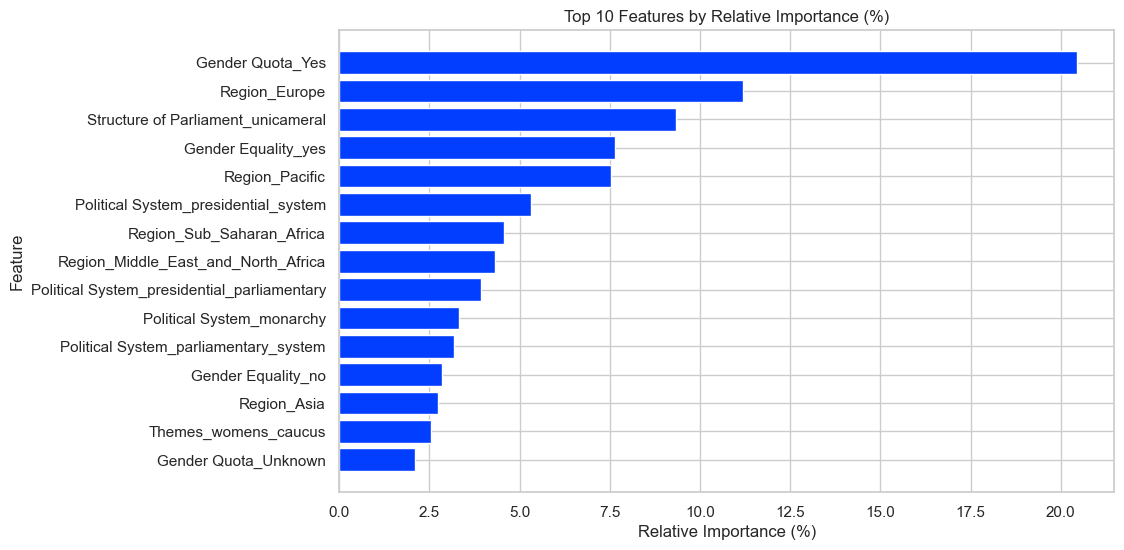

In [44]:
# Calculate relative importance as a percentage
feature_importance_df['Relative Importance (%)'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum() * 100

# Get top 10 features with their relative importance
top_features = feature_importance_df.head(15)

# Display the results
# print(top_features)
colors = sns.color_palette("bright")
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Relative Importance (%)'])
plt.gca().invert_yaxis()
plt.xlabel('Relative Importance (%)')
plt.ylabel('Feature')
plt.title('Top 10 Features by Relative Importance (%)')
plt.show()

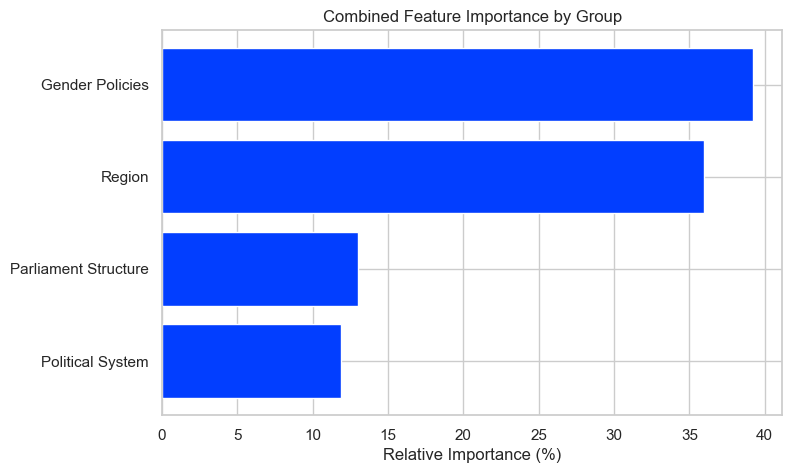

In [45]:
# Define feature groups
feature_groups = {
    "Region": ['Region_Asia', 'Region_Europe', 'Region_Pacific', 'Region_Middle_East_and_North_Africa'],
    "Political System": ['Political System_presidential_system', 'Political System_parliamentary_system'],
    "Gender Policies": ['Gender Quota_Yes', 'Gender Equality_yes'],
    "Parliament Structure": ['Structure of Parliament_unicameral'],
}

# Calculate the combined importance for each group
group_importances = {}
for group, features in feature_groups.items():
    group_importances[group] = feature_importance_df[feature_importance_df['Feature'].isin(features)]['Importance'].sum()

# Convert to a DataFrame for visualization
group_importance_df = pd.DataFrame(list(group_importances.items()), columns=['Group', 'Importance'])
group_importance_df['Relative Importance (%)'] = group_importance_df['Importance'] / group_importance_df['Importance'].sum() * 100
group_importance_df = group_importance_df.sort_values(by='Relative Importance (%)',ascending=False)
colors = sns.color_palette("bright")
plt.figure(figsize=(8, 5))
plt.barh(group_importance_df['Group'], group_importance_df['Relative Importance (%)'])
plt.gca().invert_yaxis()
plt.xlabel('Relative Importance (%)')
plt.title('Combined Feature Importance by Group')
plt.show()

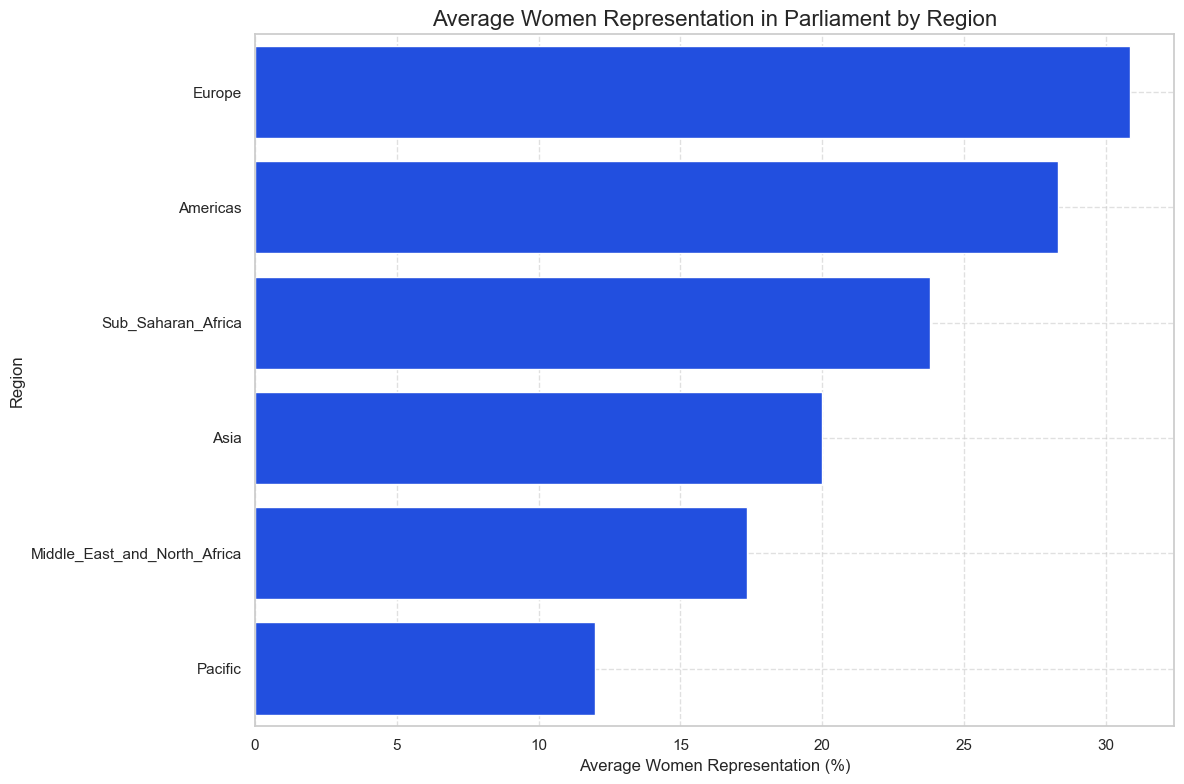

In [15]:
region_women_rep = wip_df.groupby('Region')['Lower Chamber Women (%)'].mean().reset_index()
region_women_rep = region_women_rep.sort_values(by='Lower Chamber Women (%)', ascending=False)
region_women_rep.head()
plot('bar',region_women_rep,'Lower Chamber Women (%)','Region','Average Women Representation in Parliament by Region',
     'Average Women Representation (%)','Region')

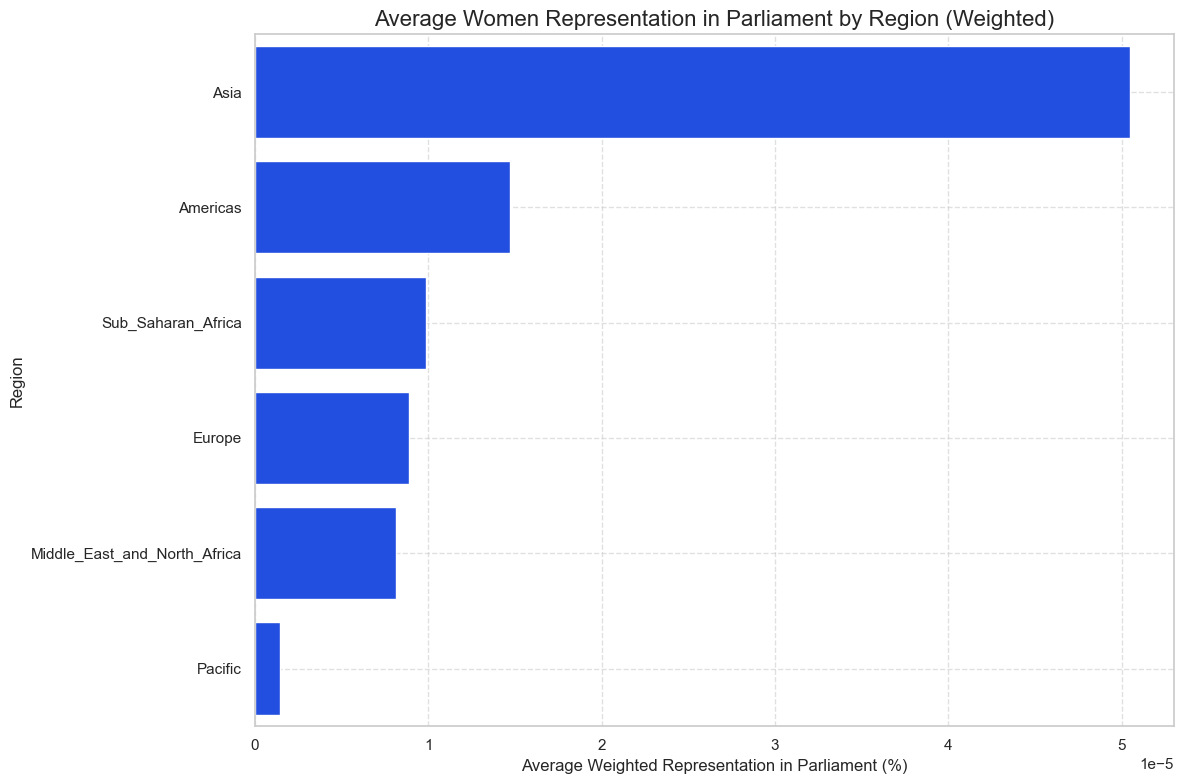

In [16]:
# Using Weighted Metric for Regional Comparison:
region_women_rep = wip_df.groupby('Region')['Weighted_Lower_Metric'].mean().reset_index()
region_women_rep = region_women_rep.sort_values(by='Weighted_Lower_Metric', ascending=False)

plot('bar', region_women_rep, 'Weighted_Lower_Metric', 'Region',
     'Average Women Representation in Parliament by Region (Weighted)',
     'Average Weighted Representation in Parliament (%)', 'Region')

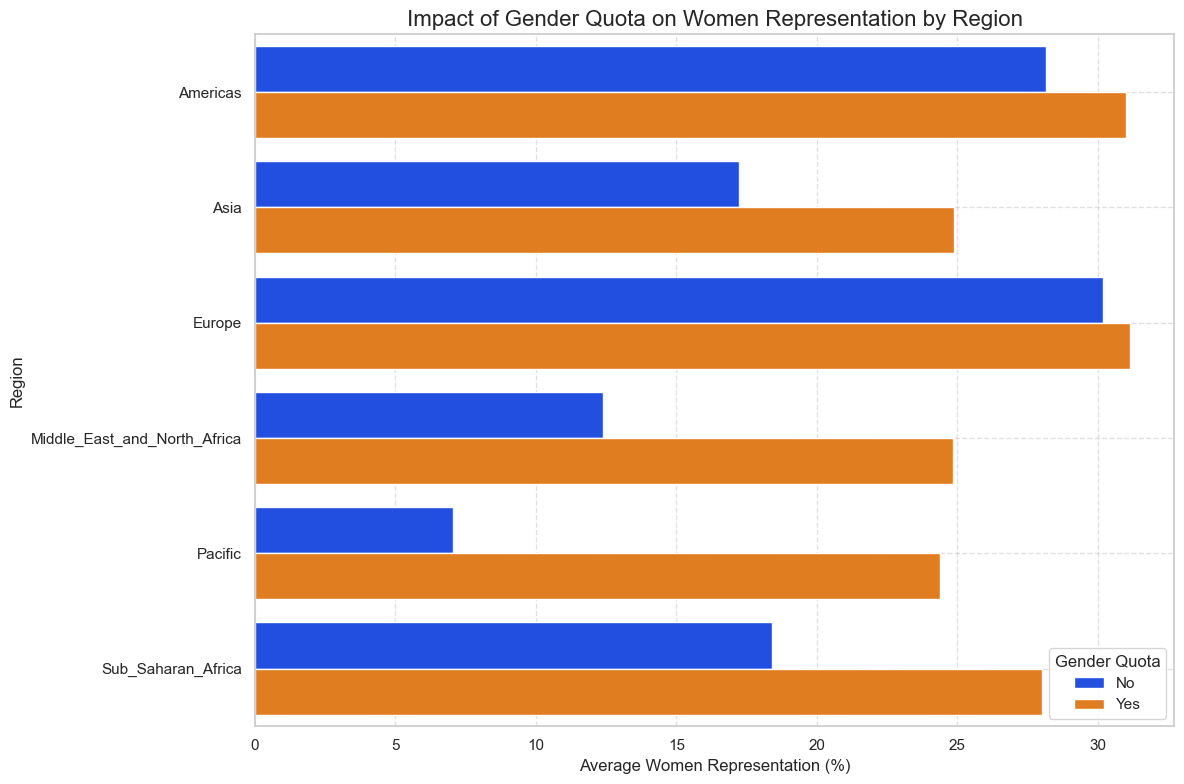

In [17]:
region_quota_impact = wip_df.groupby(['Region', 'Gender Quota'])['Lower Chamber Women (%)'].mean().reset_index()
plot('bar',region_quota_impact,'Lower Chamber Women (%)','Region','Impact of Gender Quota on Women Representation by Region',
     'Average Women Representation (%)','Region',legend=True, hue='Gender Quota')


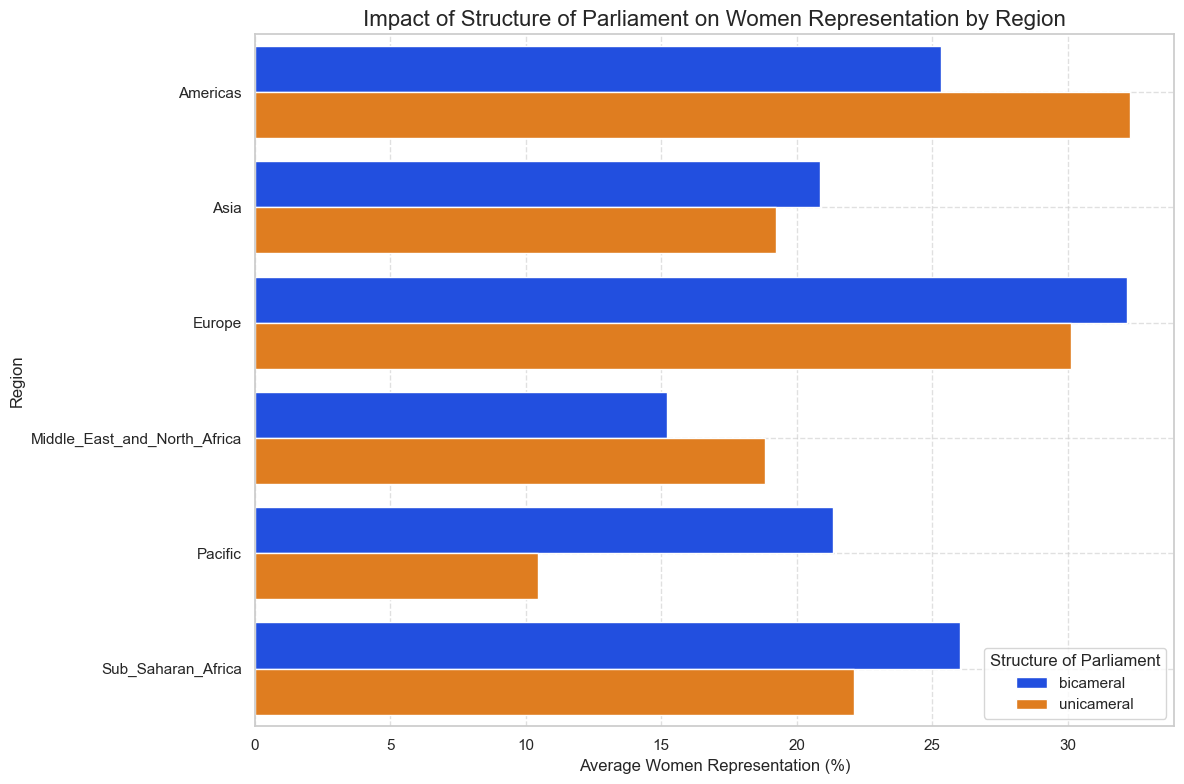

In [18]:
region_system_impact = wip_df.groupby(['Region', 'Structure of Parliament'])['Lower Chamber Women (%)'].mean().reset_index()

plot('bar',region_system_impact,'Lower Chamber Women (%)','Region','Impact of Structure of Parliament on Women Representation by Region',
     'Average Women Representation (%)','Region',legend=True, hue='Structure of Parliament')


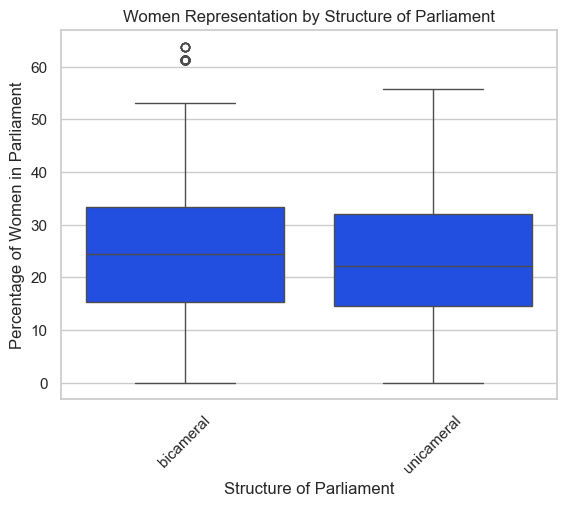

In [19]:
sns.boxplot(data=wip_df, x='Structure of Parliament', y='Lower Chamber Women (%)')
plt.title('Women Representation by Structure of Parliament')
plt.ylabel('Percentage of Women in Parliament')
plt.xlabel('Structure of Parliament')
plt.xticks(rotation=45)
plt.show()

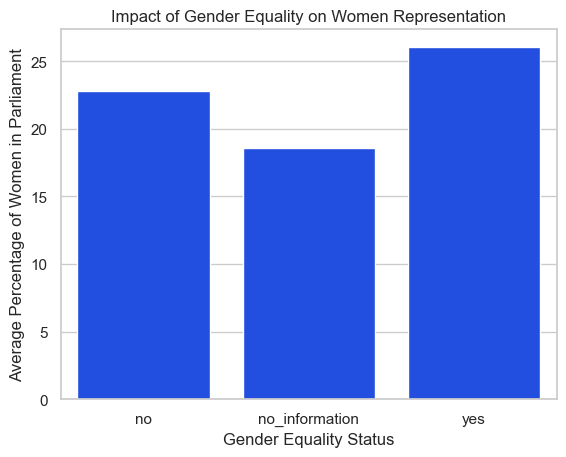

In [20]:
gender_equality_impact = wip_df.groupby('Gender Equality')['Lower Chamber Women (%)'].mean().reset_index()

sns.barplot(data=gender_equality_impact, x='Gender Equality', y='Lower Chamber Women (%)')
plt.title('Impact of Gender Equality on Women Representation')
plt.ylabel('Average Percentage of Women in Parliament')
plt.xlabel('Gender Equality Status')
plt.show()

In [21]:
# Conduct a T-test or ANOVA to check for significant differences
bicameral_data = wip_df[wip_df['Structure of Parliament'] == 'bicameral']['Lower Chamber Women (%)']
unicameral_data = wip_df[wip_df['Structure of Parliament'] == 'unicameral']['Lower Chamber Women (%)']

from scipy import stats
t_stat, p_value = stats.ttest_ind(bicameral_data, unicameral_data)
print(f'T-test Results: t-statistic = {t_stat}, p-value = {p_value}')

T-test Results: t-statistic = 6.2841196434895465, p-value = 3.394215794321791e-10


In [22]:
# Group by Political System and calculate the standard deviation for 'Lower Chamber Women (%)'
std_dev_by_structure= wip_df.groupby('Structure of Parliament')['Lower Chamber Women (%)'].std()

# Print the standard deviations
print(std_dev_by_structure)

Structure of Parliament
bicameral     12.405954
unicameral    12.691575
Name: Lower Chamber Women (%), dtype: float64


Statistical Significance (T-test): The difference in average women's representation is likely real and not due to random chance.
Similar Variance: The similarity in the spread suggests that the distribution of women's representation is similarly dispersed in both groups.

The significant difference in means (as indicated by the t-test) suggests that, on average, one group (either bicameral or unicameral) tends to have higher women representation than the other. The similar variance simply indicates that the degree of spread around the average is comparable between the two groups.

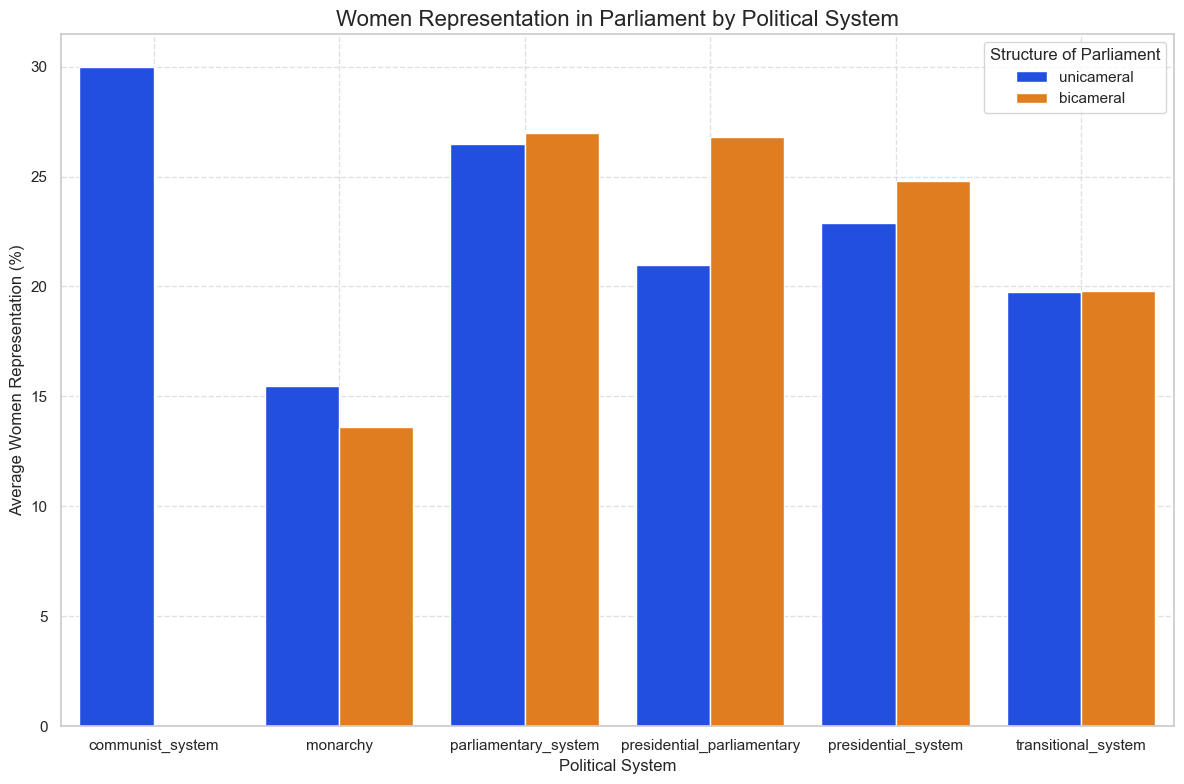

In [23]:
# Calculate average women representation in the lower chamber by political system
political_system_data = wip_df.groupby(['Political System','Structure of Parliament'])['Lower Chamber Women (%)'].mean().reset_index()

plot('bar',political_system_data,'Political System','Lower Chamber Women (%)','Women Representation in Parliament by Political System',
     'Political System','Average Women Representation (%)',legend=True, hue='Structure of Parliament')


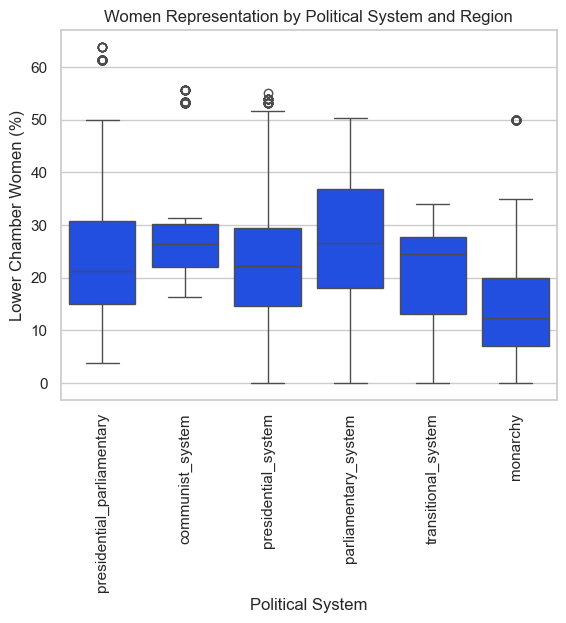

In [24]:
sns.boxplot(data=wip_df, x='Political System', y='Lower Chamber Women (%)') #,hue='Region'
plt.title('Women Representation by Political System and Region')
plt.xticks(rotation=90)
plt.show()

In [25]:
# Group by Political System and calculate the standard deviation for 'Lower Chamber Women (%)'
std_dev_by_system = wip_df.groupby('Political System')['Lower Chamber Women (%)'].std()

# Print the standard deviations
print(std_dev_by_system)

Political System
communist_system              12.693555
monarchy                      11.866845
parliamentary_system          12.270408
presidential_parliamentary    12.031734
presidential_system           12.550073
transitional_system           10.082233
Name: Lower Chamber Women (%), dtype: float64


Key Observations:

Highest Representation: Countries with a communist system have the highest average percentage of women in the lower chamber (12.69%).
Lowest Representation: Countries with a transitional system have the lowest average percentage of women (10.08%).
Other political systems (monarchy, parliamentary, presidential-parliamentary, and presidential) cluster around a similar range, between 11.87% and 12.55%.
Range of Values:

The values do not show extreme variation; the highest is 12.69%, and the lowest is 10.08%. This indicates that the political system might not have a large effect on the percentage of women in the lower chamber.

Potential Conclusion:

While the communist system seems to have slightly better representation of women in the lower chamber compared to other systems, the difference across systems is relatively small. Other factors beyond political systems (e.g., cultural, economic, or policy-related factors) might play a more significant role in determining women's representation.

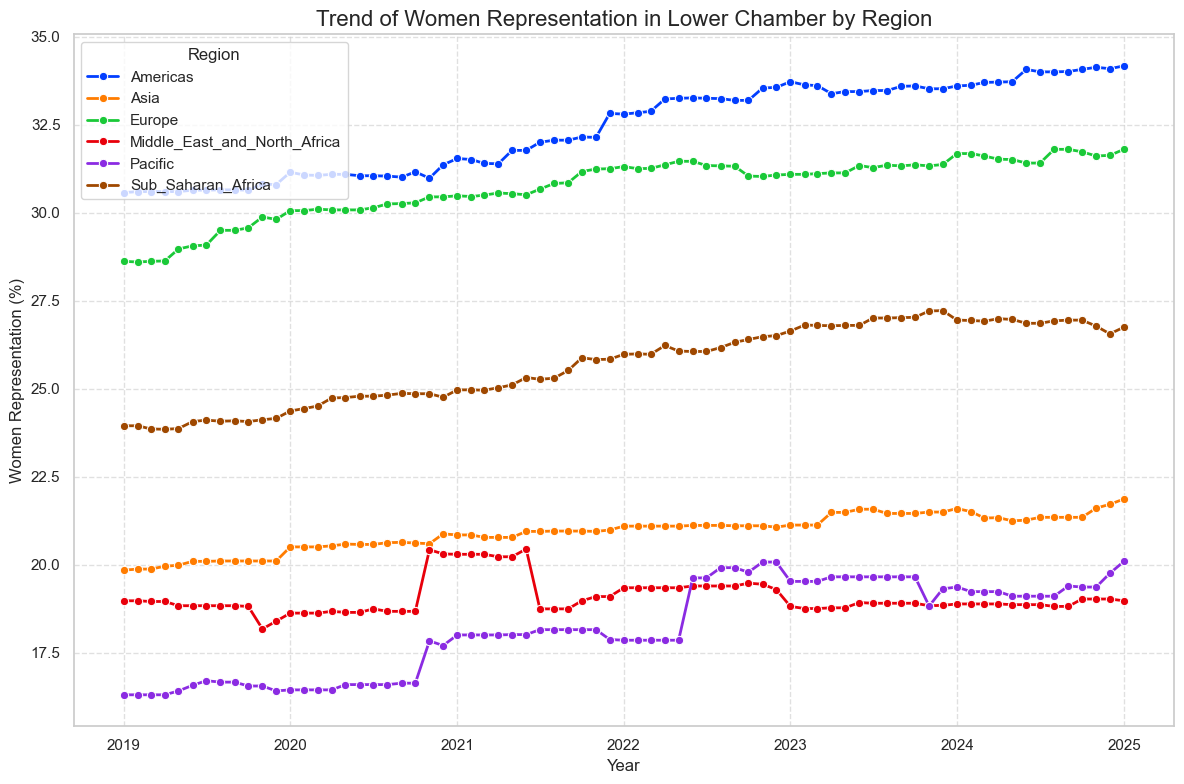

In [26]:
# Convert Year and Month columns to datetime for trend analysis
wip_df['Date'] = pd.to_datetime(wip_df[['Year', 'Month']].assign(DAY=1))

# Group data by date and region for trend analysis
trend_data = wip_df.groupby(['Date', 'Region']).agg({
    'Lower Total Women': 'sum',
    'Lower Total Seat': 'sum',
    'Upper Total Women': 'sum',
    'Upper Total Seat': 'sum'
}).reset_index()

# Calculate women's representation percentages
trend_data['Lower Chamber Women (%)'] = round((trend_data['Lower Total Women'] / trend_data['Lower Total Seat']) * 100,2)
trend_data['Upper Chamber Women (%)'] = round((trend_data['Upper Total Women'] / trend_data['Upper Total Seat']) * 100,2)

# Plot trends for the lower chamber representation by region
plot('line', trend_data, 'Date', 'Lower Chamber Women (%)','Trend of Women Representation in Lower Chamber by Region',
      'Year', 'Women Representation (%)', legend=True, hue='Region', marker='o', 
    linewidth=2)


Key Observations
Diverging Regional Trends:

Some regions show consistent improvement in women’s representation, while others remain relatively flat or stagnant.
For example, regions with steady upward trends may indicate successful policy interventions or cultural shifts toward gender inclusion.
Variability Between Regions:

There is significant variation in the percentage of women’s representation across regions. Some regions consistently outperform others, indicating disparities in political inclusion.
Sudden Changes:

Sharp increases or decreases in specific years might reflect major political reforms, quota implementations, or sociopolitical events that influenced women’s participation.
Plateaus and Saturation:

In some regions, growth appears to plateau after reaching a certain percentage, suggesting potential systemic or structural barriers limiting further progress.
Timeframe Influence:

If the dataset spans multiple decades, the gradual progress in representation highlights the long-term nature of gender equality initiatives.

C:\Users\nuwai\AppData\Local\Temp\ipykernel_4152\630602273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upper_trend_data['Date'] = pd.to_datetime(wip_df[['Year', 'Month']].assign(DAY=1))


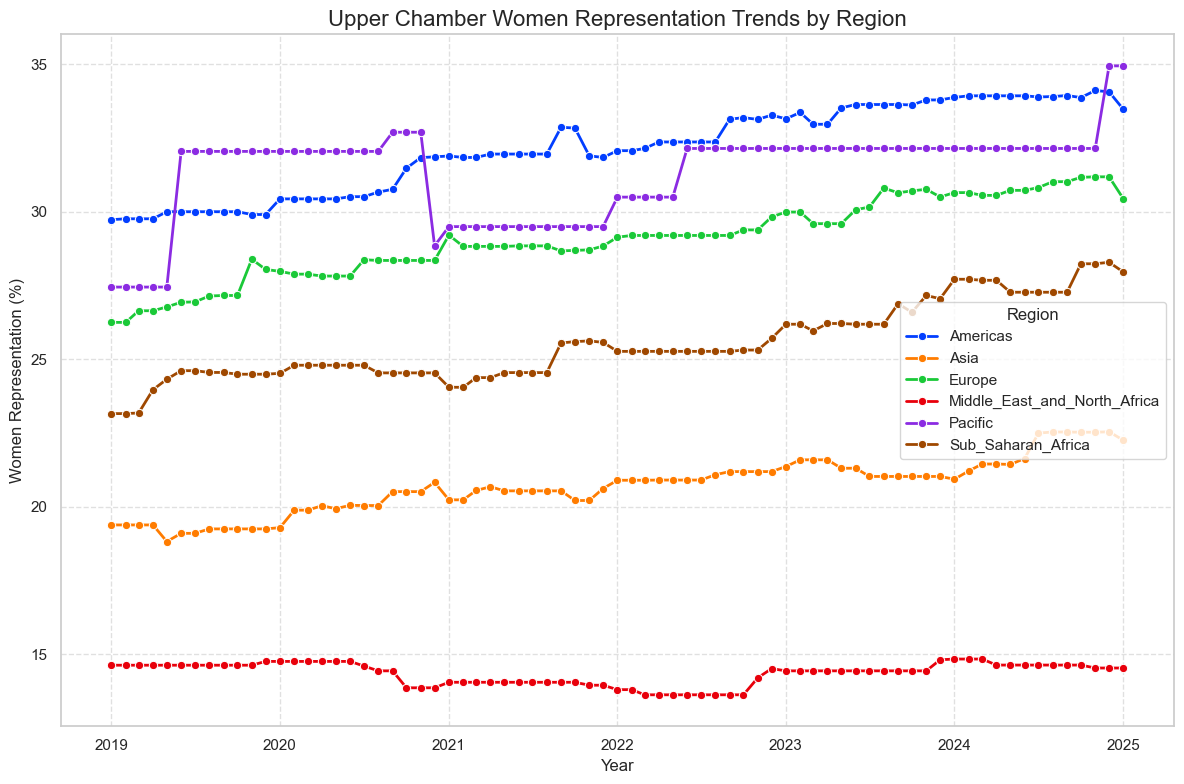

In [27]:
# Calculate trends for the upper chamber (bicameral countries only)
upper_trend_data = wip_df[wip_df['Structure of Parliament'] == 'bicameral']
upper_trend_data['Date'] = pd.to_datetime(wip_df[['Year', 'Month']].assign(DAY=1))

# Group by Region and Date for Upper Chamber Trends
upper_trend_summary = (
    upper_trend_data.groupby(['Date', 'Region'])['Upper Chamber Women (%)']
    .mean()
    .reset_index()
)
plot('line', upper_trend_summary, 'Date', 'Upper Chamber Women (%)','Upper Chamber Women Representation Trends by Region',
      'Year', 'Women Representation (%)', legend=True, hue='Region', marker='o', 
    linewidth=2)

Observations:
Variability Across Regions:

Some regions show more consistent upward trends, while others have slower growth or stagnation in representation.
Differences between regions may reflect structural or cultural disparities.
Lower Representation:

Upper chambers generally have lower percentages of women compared to lower chambers, which might indicate limited gender quotas or less emphasis on diversity in upper legislative houses.

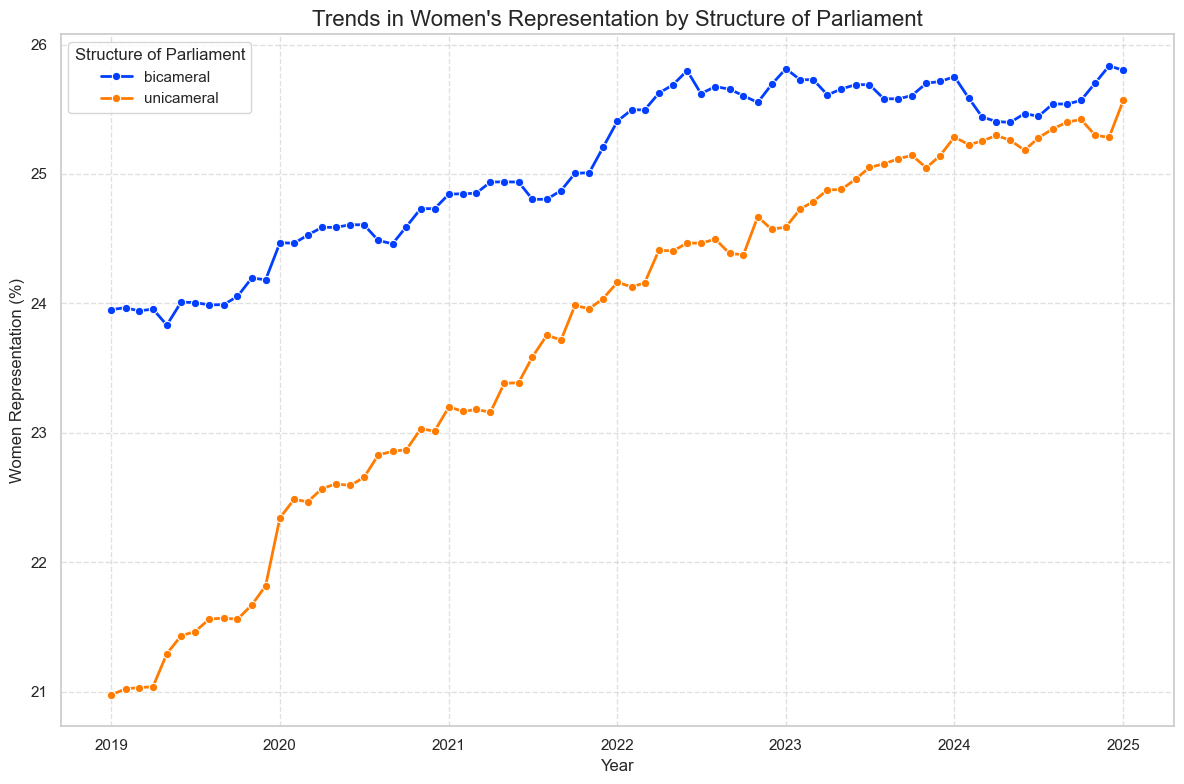

In [28]:
# Ensure data is clean and ready for plotting
filtered_df = wip_df.copy()
filtered_df['Date'] = pd.to_datetime(
    filtered_df['Year'].astype(str) + '-' + filtered_df['Month'].astype(str),
    format='%Y-%m'
)

# Aggregate data by Structure of Parliament and Date
representation_trends = (
    filtered_df.groupby(['Date', 'Structure of Parliament'])
    [['Lower Chamber Women (%)', 'Upper Chamber Women (%)']]
    .mean()
    .reset_index()
)


plot('line', representation_trends, 'Date','Lower Chamber Women (%)', "Trends in Women's Representation by Structure of Parliament",
      'Year', 'Women Representation (%)', legend=True, hue='Structure of Parliament', marker='o', 
    linewidth=2)


In [29]:
# # Sort data by Country and Year
# wip_df_sorted = wip_df.sort_values(by=['Country', 'Year'])

# # Filter out rows where 'Lower Total Women' is zero
# wip_df_sorted_filtered = wip_df_sorted[wip_df_sorted['Lower Total Women'] != 0]


# # Calculate Year-on-Year improvement for each country
# wip_df_sorted_filtered['YoY Improvement (%)'] = (
#     wip_df_sorted_filtered.groupby('Country')['Lower Chamber Women (%)']
#     .pct_change() * 100  # Convert to percentage
# )

# # Display countries with significant YoY improvement
# significant_improvements = wip_df_sorted_filtered[wip_df_sorted_filtered['YoY Improvement (%)'] > 10]
# significant_improvements.head()

In [30]:
# Step 1: Sort data by Country and Year
wip_df_sorted = wip_df.sort_values(by=['Country', 'Year'])

# Step 2: Remove rows where 'Lower Total Women' is zero (keeping only valid records)
wip_df_sorted_filtered = wip_df_sorted[wip_df_sorted['Lower Total Women'] != 0]

# Step 3: Identify countries where 'Lower Chamber Women (%)' has ever been zero
# exclude the countries where data is 0, this could lead to bias in YoY improvement 
countries_with_zero = wip_df_sorted.groupby('Country')['Lower Chamber Women (%)'].apply(lambda x: (x == 0).any())

# Step 4: Keep only countries where 'Lower Chamber Women (%)' has never been zero
valid_countries = countries_with_zero[~countries_with_zero].index  # Extract only country names

wip_df_valid = wip_df_sorted_filtered[wip_df_sorted_filtered['Country'].isin(valid_countries)]

# Step 5: Calculate Year-on-Year Improvement only for valid countries
wip_df_valid['YoY Improvement (%)'] = (
    wip_df_valid.groupby('Country')['Lower Chamber Women (%)']
    .pct_change() * 100  # Convert to percentage
)

# Step 6: Display countries with significant YoY improvement (above 10%)
significant_improvements = wip_df_valid[wip_df_valid['YoY Improvement (%)'] > 10]

significant_improvements.head()

C:\Users\nuwai\AppData\Local\Temp\ipykernel_4152\2921054777.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wip_df_valid['YoY Improvement (%)'] = (


,Unnamed: 0,Year,Month,Country,Country Code,Region,Subregion,Lower Total Seat,Lower Total Women,Lower Chamber Women (%),...,Themes,Gender Quota,Population_Weight,Weighted_Lower_Metric,Weighted_Upper_Metric,Weighted_Bicameral_Metric,Weighted_Lower_Rank,Weighted_Bicameral_Rank,Date,YoY Improvement (%)
5446,5446,2021,5,Albania,AL,Europe,central_and_eastern_europe,140,47,33.6,...,gender_equality,Yes,5.020000e-06,1.680000e-06,NaN,1.680000e-06,120,NaN,2021-05-01,13.898305
784,784,2019,5,Andorra,AD,Europe,western_europe,28,12,42.9,...,foreign_affairs,No,1.370000e-07,5.880000e-08,NaN,5.880000e-08,171,NaN,2019-05-01,33.644860
968,968,2019,6,Andorra,AD,Europe,western_europe,28,14,50.0,...,foreign_affairs,No,1.370000e-07,6.860000e-08,NaN,6.860000e-08,169,NaN,2019-06-01,16.550117
8541,8541,2022,9,Angola,AO,Sub_Saharan_Africa,southern_africa,220,74,33.6,...,human_rights,Yes,6.270000e-05,2.110000e-05,NaN,2.110000e-05,32,NaN,2022-09-01,13.513514
8716,8716,2022,10,Angola,AO,Sub_Saharan_Africa,southern_africa,220,86,39.1,...,human_rights,Yes,6.270000e-05,2.450000e-05,NaN,2.450000e-05,25,NaN,2022-10-01,16.369048


In [31]:
# # Step 1: Sort data by Country and Year
# wip_df_sorted = wip_df.sort_values(by=['Country', 'Year'])

# # Step 2: Remove rows where 'Weighted Lower Metric' is zero (keeping only valid records)
# wip_df_sorted_filtered = wip_df_sorted[wip_df_sorted['Weighted_Lower_Metric'] != 0]

# # Step 3: Identify countries where 'Lower Chamber Women (%)' has ever been zero
# # exclude the countries where data is 0, this could lead to bias in YoY improvement 
# countries_with_zero = wip_df_sorted.groupby('Country')['Weighted_Lower_Metric'].apply(lambda x: (x == 0).any())

# # Step 4: Keep only countries where 'Lower Chamber Women (%)' has never been zero
# valid_countries = countries_with_zero[~countries_with_zero].index  # Extract only country names

# wip_df_valid = wip_df_sorted_filtered[wip_df_sorted_filtered['Country'].isin(valid_countries)]

# # Step 5: Calculate Year-on-Year Improvement only for valid countries
# wip_df_valid['YoY Improvement (%)'] = (
#     wip_df_valid.groupby('Country')['Weighted_Lower_Metric']
#     .pct_change() * 100  # Convert to percentage
# )

# # Step 6: Display countries with significant YoY improvement (above 10%)
# significant_improvements = wip_df_valid[wip_df_valid['YoY Improvement (%)'] > 10]

# # Sort in descending order
# significant_improvements_sorted = significant_improvements.sort_values(by='YoY Improvement (%)', ascending=False)

# significant_improvements.head()

In [32]:
total_improvement = (
    significant_improvements.groupby('Country')['YoY Improvement (%)']
    .mean()
    .sort_values(ascending=False)
)
print(total_improvement.head(10))  # Top 10 improvers

Country
Palau                    296.825397
Burkina Faso             212.698413
Mali                     193.684211
Comoros                  173.770492
Liechtenstein            133.333333
Benin                    131.981982
Sierra Leone             116.923077
Malta                    108.208955
Saint Kitts and Nevis    106.443995
Thailand                 104.127622
Name: YoY Improvement (%), dtype: float64


In [33]:
#total_improvement['Region'].value_counts()

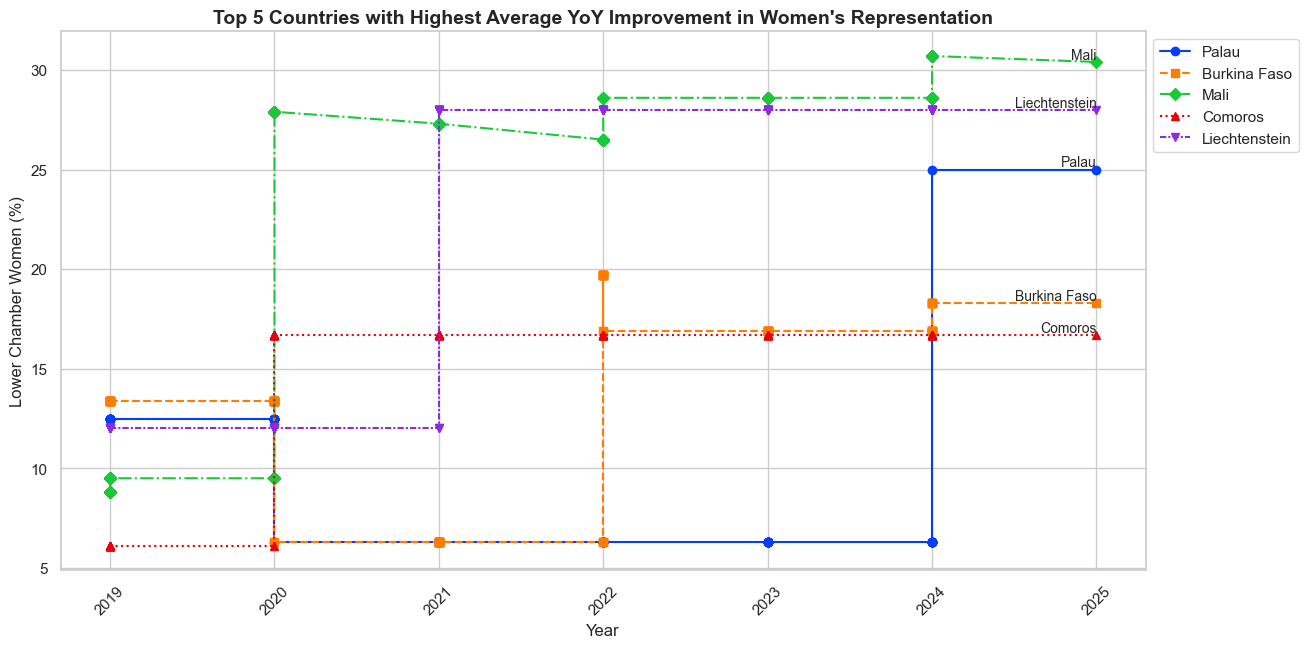

In [34]:
top_countries = total_improvement.head(10).index
top_countries_data = wip_df_sorted_filtered[wip_df_sorted_filtered['Country'].isin(top_countries)]

sns.set_style("whitegrid")

plt.figure(figsize=(14, 7))

styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2, 2, 2))]
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'X', '<', '>']

for i, country in enumerate(top_countries[:5]):  # Limiting to top 5 for consistency
    country_data = top_countries_data[top_countries_data['Country'] == country]
    plt.plot(country_data['Year'], country_data['Lower Chamber Women (%)'], label=country, linestyle=styles[i % len(styles)], marker=markers[i % len(markers)])

    # Annotate last data point
    last_year = country_data['Year'].iloc[-1]
    last_value = country_data['Lower Chamber Women (%)'].iloc[-1]
    plt.text(last_year, last_value, country, fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.xlabel("Year", fontsize=12)
plt.ylabel("Lower Chamber Women (%)", fontsize=12)
plt.title("Top 5 Countries with Highest Average YoY Improvement in Women's Representation", fontsize=14, fontweight='bold')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.show()

In [35]:
# from scipy.stats import chi2_contingency

# contingency_table = pd.crosstab(wip_df_sorted_filtered['Political System'], wip_df_sorted_filtered['YoY Improvement (%)'] > 0)
# chi2, p, _, _ = chi2_contingency(contingency_table)
# print(f"Chi-Square Test p-value: {p}")

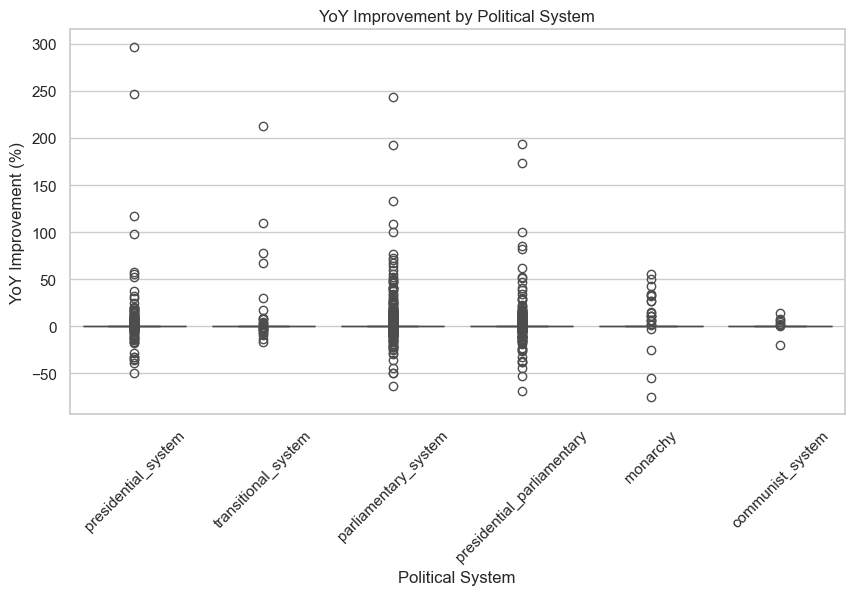

In [36]:
wip_df_valid.groupby("Political System")["YoY Improvement (%)"].mean().sort_values(ascending=False)

# plot('box',wip_df_valid,"Political System","YoY Improvement (%)","YoY Improvement by Political System",
#      "Political System","YoY Improvement (%)",figsize=(10,5),rotation=45)
plt.figure(figsize=(10, 5))
sns.boxplot(x="Political System", y="YoY Improvement (%)", data=wip_df_valid)
plt.xticks(rotation=45)
plt.title("YoY Improvement by Political System")
plt.show()


# sns.boxplot(data=wip_df, x='Political System', y='Lower Chamber Women (%)') #,hue='Region'
# plt.title('Women Representation by Political System and Region')
# plt.xticks(rotation=90)
# plt.show()

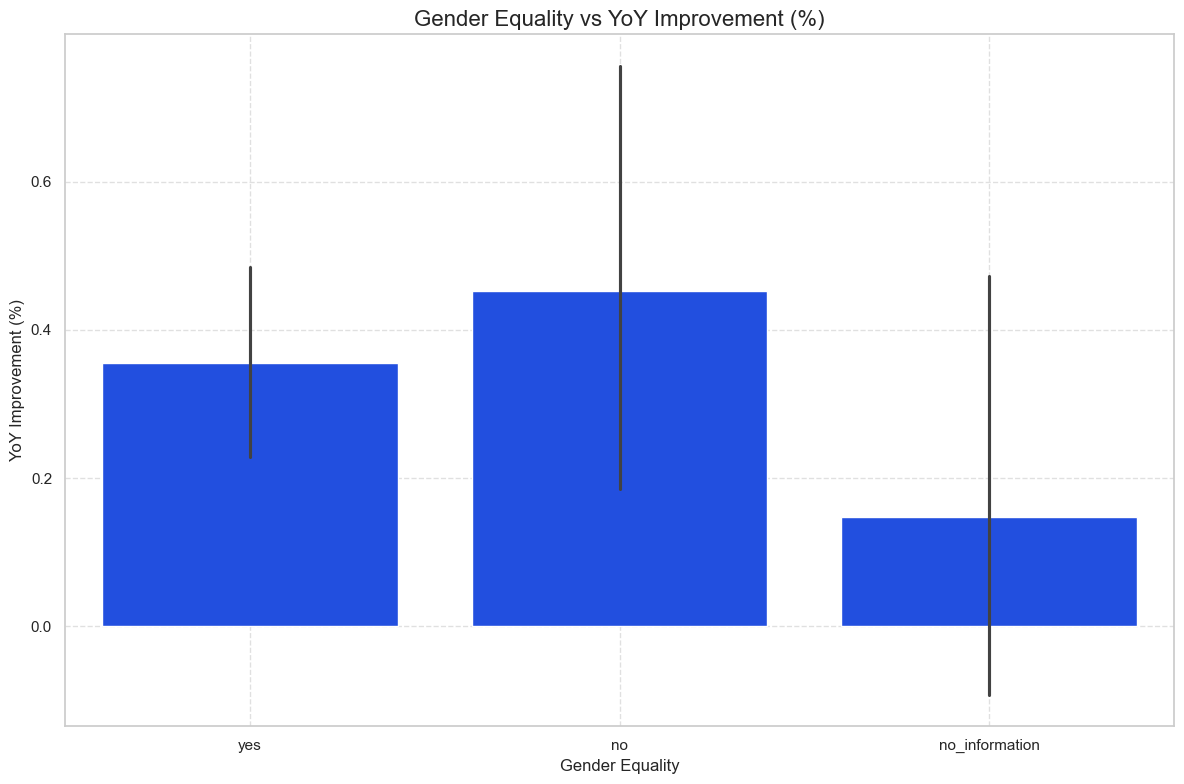

In [37]:
# sns.heatmap(wip_df_sorted_filtered[['YoY Improvement (%)', 'Gender Equality', 'Political System','Structure of Parliament']].corr(), annot=True, cmap='coolwarm')
# plt.show()
#wip_df_sorted_filtered['Gender Equality'] = wip_df_sorted_filtered['Gender Equality'].map({'yes': 1, 'no': 0})

plot('bar', wip_df_valid,'Gender Equality', 'YoY Improvement (%)', 
     'Gender Equality vs YoY Improvement (%)','Gender Equality', 'YoY Improvement (%)')
# plt.barplot(wip_df_sorted_filtered['Gender Equality'], wip_df_sorted_filtered['YoY Improvement (%)'])
# plt.xlabel('Gender Equality')
# plt.ylabel('YoY Improvement (%)')
# plt.title('Gender Equality vs YoY Improvement (%)')
# plt.show()

In [38]:
std_dev_by_gender= wip_df_valid.groupby('Gender Equality')['Lower Chamber Women (%)'].std()
std_dev_by_gender


Gender Equality
no                12.000396
no_information    10.730188
yes               12.027028
Name: Lower Chamber Women (%), dtype: float64

In [39]:
# Grouping by Region and Country to calculate average women representation in both chambers
top_countries = wip_df.groupby(['Region', 'Country']).agg({
    'Lower Chamber Women (%)': 'mean',
    'Upper Chamber Women (%)': 'mean'
}).reset_index()

# Sorting the countries within each region by women representation in the lower chamber
top_countries['Lower Chamber Rank'] = top_countries.groupby('Region')['Lower Chamber Women (%)'].rank(method='dense',ascending=False)

# # Sorting the countries within each region by women representation in the upper chamber
# top_countries['Upper Chamber Rank'] = top_countries.groupby('Region')['Upper Chamber Women (%)'].rank(ascending=False)

# # You can also sort by combined ranking if desired, e.g., by average rank across both chambers
# top_countries['Average Rank'] = (top_countries['Lower Chamber Rank'] + top_countries['Upper Chamber Rank']) / 2
top_countries_sorted = top_countries.sort_values('Lower Chamber Rank')

# Display the top countries for each region
top_countries_sorted.head()


,Region,Country,Lower Chamber Women (%),Upper Chamber Women (%),Lower Chamber Rank
12,Americas,Cuba,54.027397,0.000000,1.0
67,Europe,Andorra,46.850685,0.000000,1.0
131,Middle_East_and_North_Africa,United Arab Emirates,46.027397,0.000000,1.0
62,Asia,Timor-Leste,38.464384,0.000000,1.0
181,Sub_Saharan_Africa,Rwanda,61.505479,37.580822,1.0


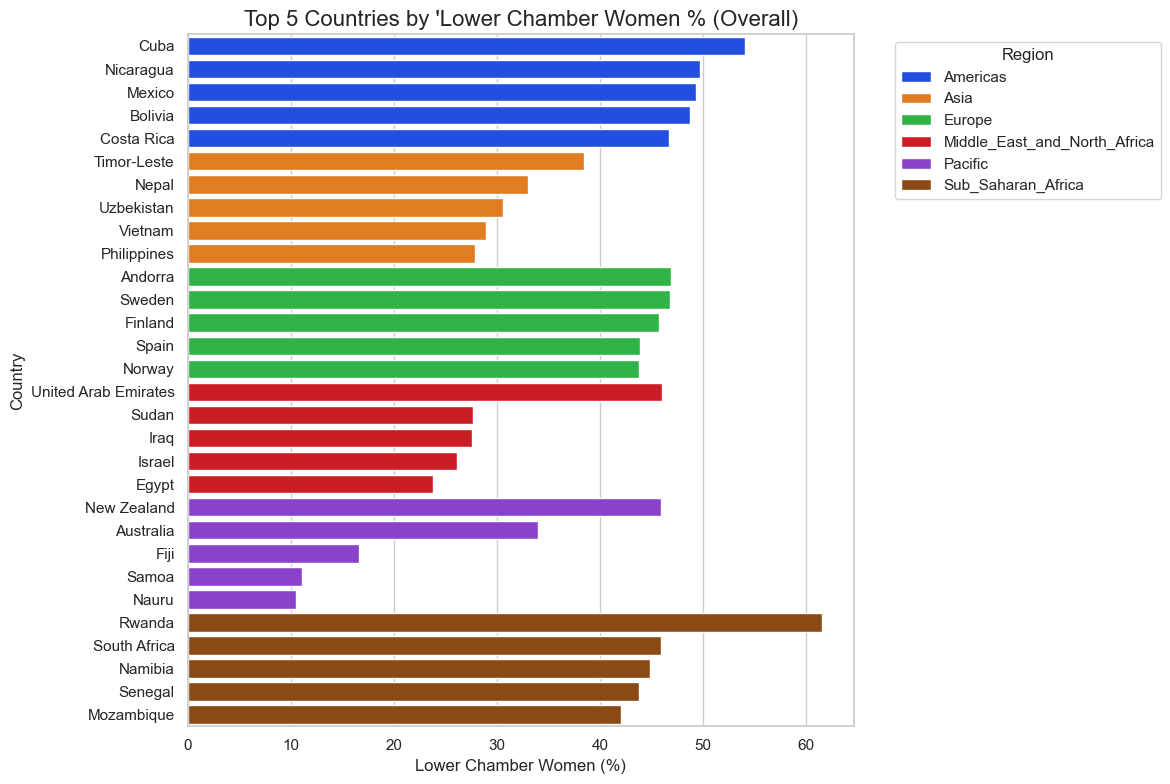

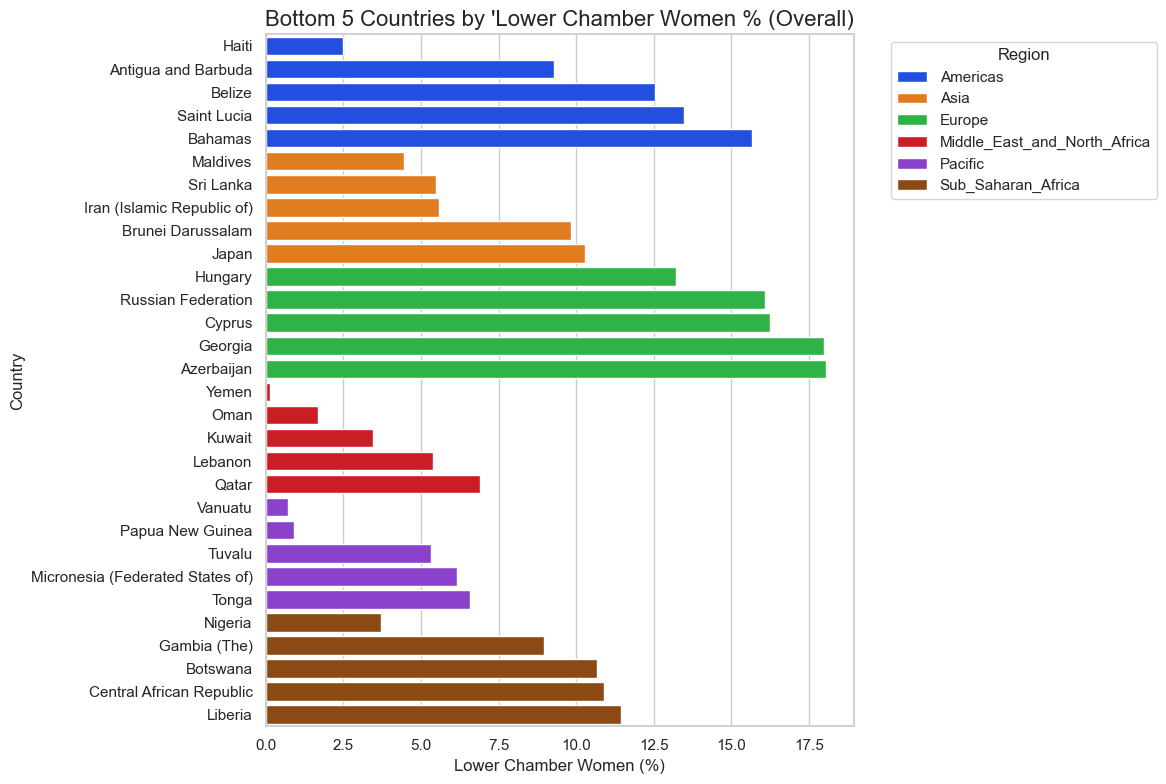

In [40]:
# Group by Region and Country, calculate mean Lower Chamber Women (%)
# aggregated_data = (
#     wip_df.groupby(['Region', 'Country'])['Lower Chamber Women (%)']
#     .mean()
#     .reset_index()
# )

# Get top 5 countries for each region
top_5_aggregated = (
    top_countries
    .sort_values(by=['Region', 'Lower Chamber Women (%)'], ascending=[True, False])  # Ensure sorting by region and %
    .groupby('Region')
    .head(5)  # Select top 5 within each region
    .reset_index(drop=True)
)

bottom_5_aggregated =  (
    top_countries
    .sort_values(by=['Region', 'Lower Chamber Women (%)'], ascending=[True, True])  # Ensure sorting by region and rank
    .groupby('Region')
    .head(5)  # Select top 5 within each region
    .reset_index(drop=True)
)

# Display the result
top_5_aggregated.head()
bottom_5_aggregated.head()


plot('bar', top_5_aggregated, 'Lower Chamber Women (%)','Country', "Top 5 Countries by 'Lower Chamber Women % (Overall)",
      'Lower Chamber Women (%)', 'Country', legend=True, hue='Region',dodge=False,grid=False,
      legend_kwargs={"bbox_to_anchor": (1.05, 1), "loc": "upper left"})

plot('bar', bottom_5_aggregated, 'Lower Chamber Women (%)','Country', "Bottom 5 Countries by 'Lower Chamber Women % (Overall)",
      'Lower Chamber Women (%)', 'Country', legend=True, hue='Region',dodge=False,grid=False,
      legend_kwargs={"bbox_to_anchor": (1.05, 1), "loc": "upper left"})

C:\Users\nuwai\AppData\Local\Temp\ipykernel_4152\3061174220.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['Gender Equality'] = top_5_df['Gender Equality'].map({'yes':'GE_yes', 'no': 'GE_no', 'no_information': 'GE_NA'})
C:\Users\nuwai\AppData\Local\Temp\ipykernel_4152\3061174220.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_5_df['Gender Equality'] = bottom_5_df['Gender Equality'].map({'yes':'GE_yes', 'no': 'GE_no', 'no_information': 'GE_NA'})


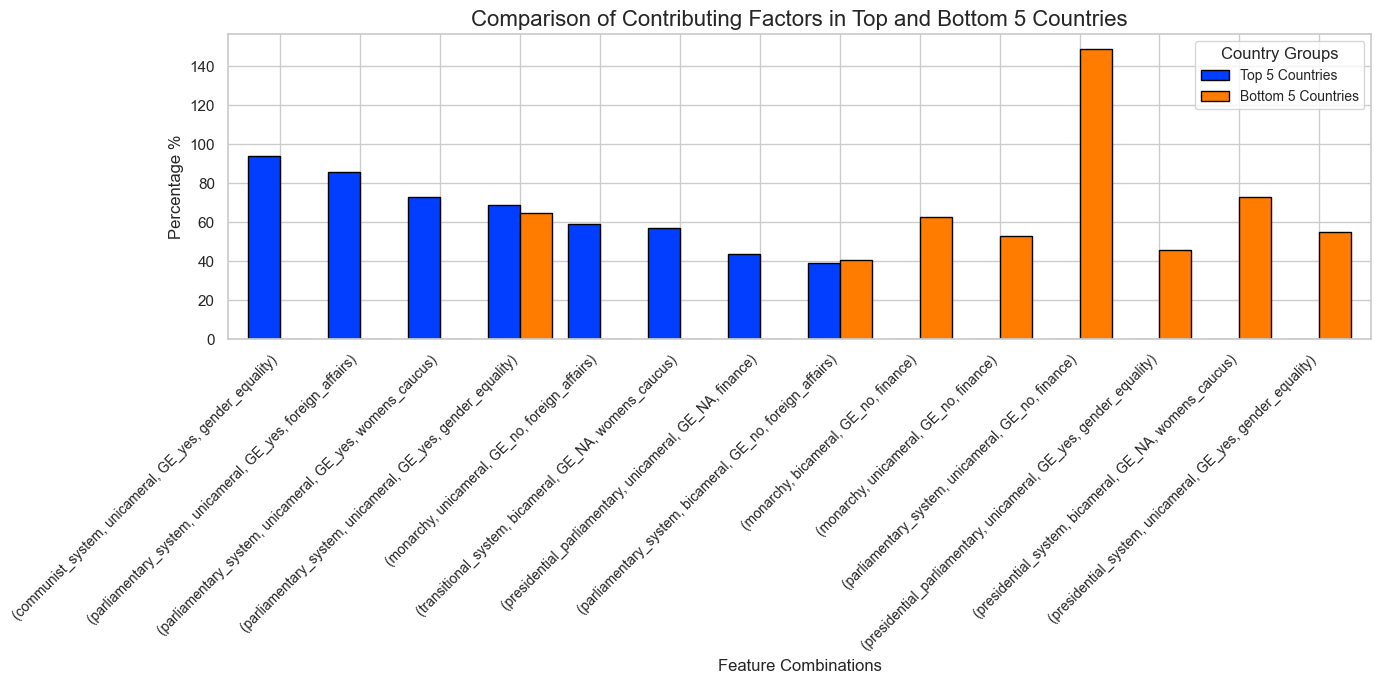

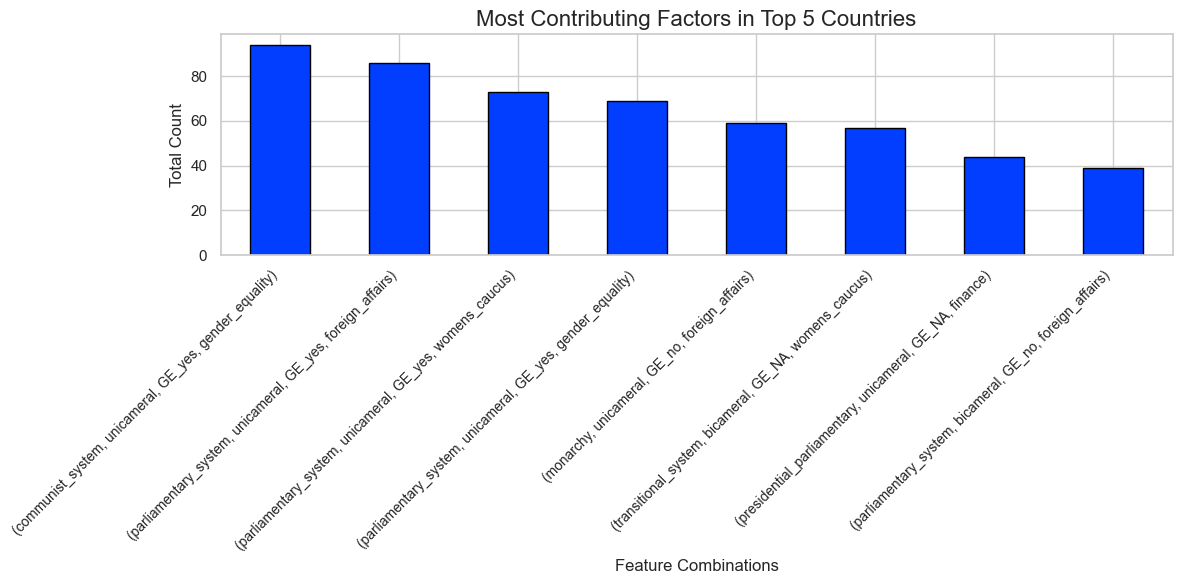

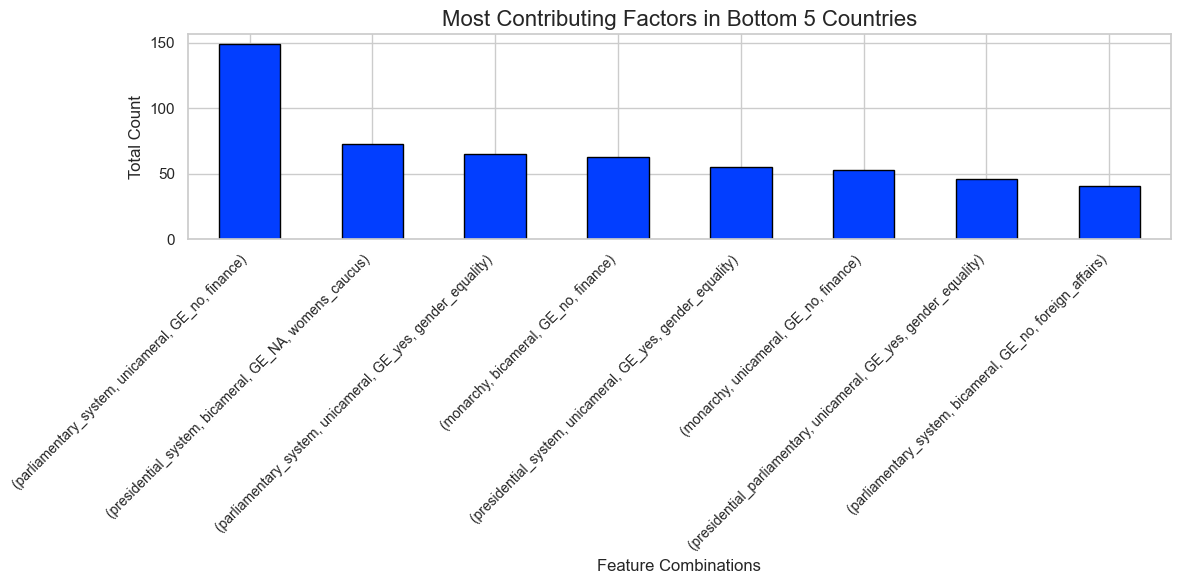

In [47]:
# Extract country lists
top_5_countries = top_5_aggregated['Country'].unique()
bottom_5_countries = bottom_5_aggregated['Country'].unique()

# Filter wip_df to only include these countries
top_5_df = wip_df[wip_df['Country'].isin(top_5_countries)]
bottom_5_df = wip_df[wip_df['Country'].isin(bottom_5_countries)]


top_5_df['Gender Equality'] = top_5_df['Gender Equality'].map({'yes':'GE_yes', 'no': 'GE_no', 'no_information': 'GE_NA'})
bottom_5_df['Gender Equality'] = bottom_5_df['Gender Equality'].map({'yes':'GE_yes', 'no': 'GE_no', 'no_information': 'GE_NA'})

#top_5_df=top_5_df.groupby(['Country','Political System', 'Structure of Parliament', 'Gender Equality', 'Themes'])['Lower Chamber Women (%)'].mean()
#bottom_5_df =bottom_5_df .groupby(['Country','Political System', 'Structure of Parliament', 'Gender Equality', 'Themes'])['Lower Chamber Women (%)'].mean()

top_5_df=top_5_df.groupby(['Country','Political System', 'Structure of Parliament', 'Gender Equality', 'Themes']).size().reset_index(name='Count')
top_5_df = top_5_df.sort_values(by='Count',ascending=False).head(10)

bottom_5_df=bottom_5_df.groupby(['Country','Political System', 'Structure of Parliament', 'Gender Equality', 'Themes']).size().reset_index(name='Count')
bottom_5_df = bottom_5_df.sort_values(by='Count',ascending=False).head(10)


# # Aggregate to count occurrences across all features
# top_5_summary = (
#     top_5_df.reset_index()
#     .groupby(['Political System', 'Structure of Parliament', 'Gender Equality', 'Themes'])
#     .size()
#     .reset_index(name='Count')
# )
# top_5_summary.head()

#top_5_summary.sort_values(by='Count',ascending=False).head()

# # Create a pivot table with all features in the index
# comprehensive_matrix = top_5_summary.pivot_table(
#     index=['Political System', 'Structure of Parliament', 'Gender Equality'],
#     columns='Themes',
#     values='Count',
#     aggfunc='sum'
# ).fillna(0)

# comprehensive_matrix

# Aggregate counts for each feature
top_total_contributions = top_5_df.groupby(['Political System', 'Structure of Parliament', 'Gender Equality','Themes'])['Count'].sum().sort_values(ascending=False).head(10)
bottom_total_contributions = bottom_5_df.groupby(['Political System', 'Structure of Parliament', 'Gender Equality','Themes'])['Count'].sum().sort_values(ascending=False).head(10)


# Combine contributions into a single DataFrame, keeping them separate
combined_contributions = pd.DataFrame({
    'Top 5 Countries': top_total_contributions,
    'Bottom 5 Countries': bottom_total_contributions
}).fillna(0)  # Fill NaN values with 0 if any

# Sort based only on the Top 5 Countries
combined_contributions = combined_contributions.sort_values(by='Top 5 Countries', ascending=False)

# Plot grouped bar chart
combined_contributions.plot(kind='bar', figsize=(14, 7), edgecolor='black', width=0.8)
plt.title('Comparison of Contributing Factors in Top and Bottom 5 Countries', fontsize=16)
plt.xlabel('Feature Combinations', fontsize=12)
plt.ylabel('Percentage %', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title="Country Groups", fontsize=10)
plt.tight_layout()
plt.show()

#for df in [top_total_contributions,bottom_total_contributions]:
top_total_contributions.plot(kind='bar', figsize=(12, 6), edgecolor='black')
plt.title('Most Contributing Factors in Top 5 Countries', fontsize=16)
plt.xlabel('Feature Combinations', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

bottom_total_contributions.plot(kind='bar', figsize=(12, 6), edgecolor='black')
plt.title('Most Contributing Factors in Bottom 5 Countries', fontsize=16)
plt.xlabel('Feature Combinations', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

# # Heatmap for the comprehensive matrix
# plt.figure(figsize=(14, 10))
# sns.heatmap(comprehensive_matrix, annot=True, cmap='coolwarm', fmt=".0f", linewidths=0.5)
# plt.title('Feature Distribution Across All Dimensions', fontsize=16)
# plt.xlabel('Themes', fontsize=12)
# plt.ylabel('Feature Combinations', fontsize=12)
# plt.xticks(rotation=45, ha='right', fontsize=10)
# plt.tight_layout()
# plt.show()

In [42]:
wip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14089 entries, 0 to 14088
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Unnamed: 0                 14089 non-null  int64         
 1   Year                       14089 non-null  int64         
 2   Month                      14089 non-null  int64         
 3   Country                    14089 non-null  object        
 4   Country Code               14089 non-null  object        
 5   Region                     14089 non-null  object        
 6   Subregion                  14089 non-null  object        
 7   Lower Total Seat           14089 non-null  int64         
 8   Lower Total Women          14089 non-null  int64         
 9   Lower Chamber Women (%)    14089 non-null  float64       
 10  Upper Total Seat           14089 non-null  int64         
 11  Upper Total Women          14089 non-null  int64         
 12  Uppe

In [24]:
# pip install ploty

In [29]:
# Sort the dataframe by Year, Region, and Weighted_Lower_Rank
wip_df_sorted = wip_df.sort_values(by=["Year", "Region", "Weighted_Lower_Rank"])

# Group by Year and Region, then get the top 5 countries for each group
top_5_ranked = (
    wip_df_sorted.groupby(["Year", "Region"])
    .head(5)  # Select top 5 rows from each group
    .reset_index(drop=True)
)

# Display the result
print(top_5_ranked[["Year", "Region", "Country", "Weighted_Lower_Rank"]])

     Year              Region                      Country  \
0    2019            americas     United States of America   
1    2019            americas     United States of America   
2    2019            americas     United States of America   
3    2019            americas     United States of America   
4    2019            americas     United States of America   
..    ...                 ...                          ...   
205  2025  sub_saharan_africa                     Ethiopia   
206  2025  sub_saharan_africa                 South Africa   
207  2025  sub_saharan_africa  United Republic of Tanzania   
208  2025  sub_saharan_africa                       Uganda   
209  2025  sub_saharan_africa                       Angola   

     Weighted_Lower_Rank  
0                      3  
1                      3  
2                      3  
3                      3  
4                      3  
..                   ...  
205                    6  
206                   14  
207         

C:\Users\nuwai\AppData\Local\Temp\ipykernel_4968\889848623.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(data=data, x=x, y=y, hue=hue, palette="bright", **kwargs)


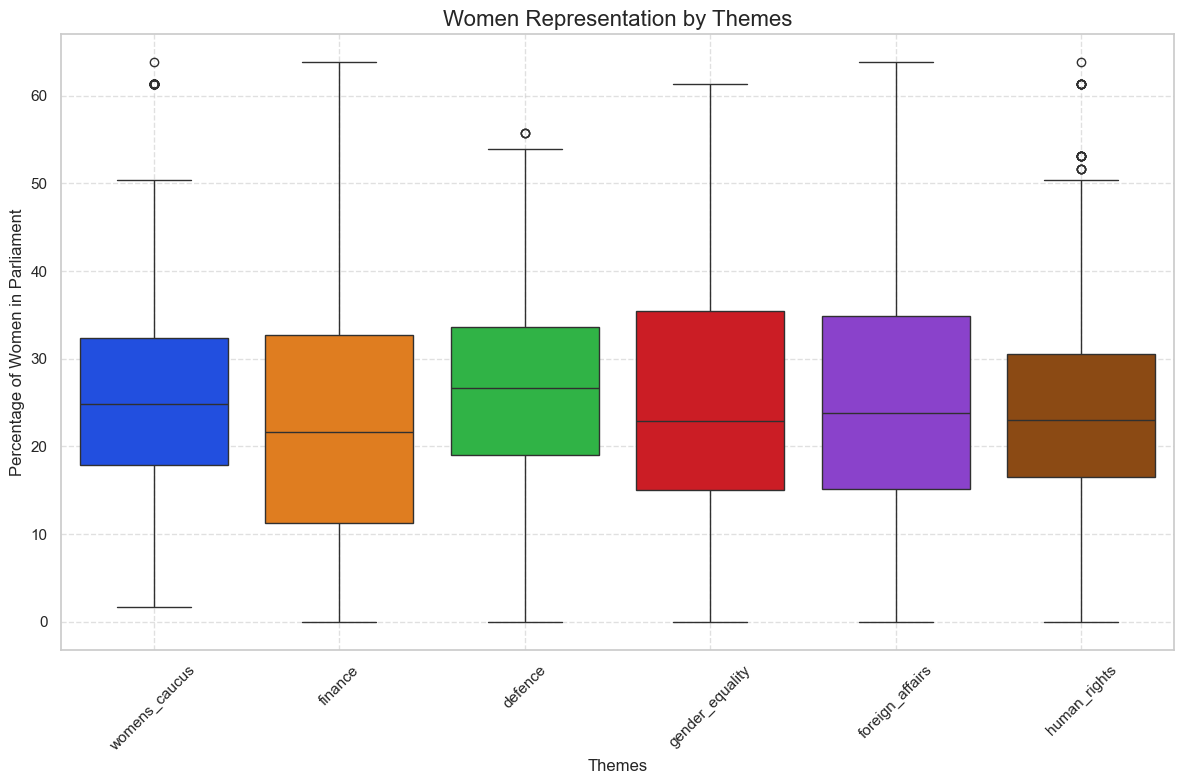

In [ ]:
plot('box',wip_df,'Themes','Lower Chamber Women (%)','Women Representation by Themes','Themes',
     'Percentage of Women in Parliament',rotation=45)

In [48]:
# from scipy.stats import chi2_contingency

# # Chi-square test for 'Themes' and Women's Representation
# themes_crosstab = pd.crosstab(wip_df['Themes'], wip_df['Gender Equality'])
# chi2, p, dof, expected = chi2_contingency(themes_crosstab)
# print(f"Chi-Square Test for Themes & Gender Equality: Chi2 = {chi2:.2f}, P-value = {p:.4f}")